Loaded meta_train.csv. Shape: (10407, 4)


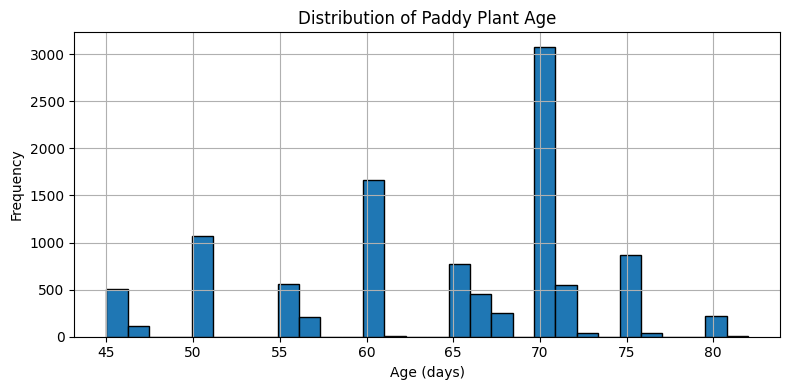

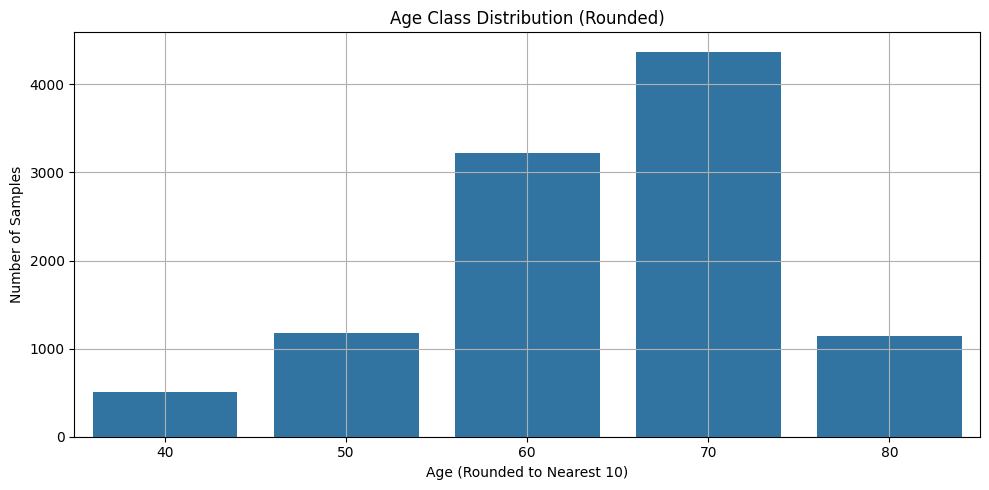

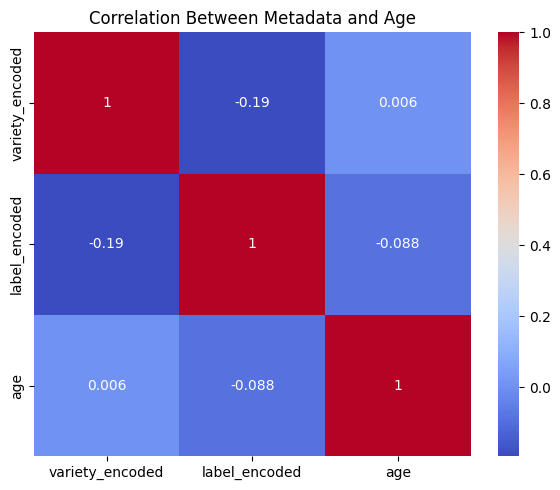

Found image: 100330.jpg
Original size: (480, 640)


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# === Future-Proof Path Setup === #
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))

PATHS = {
    "csv": os.path.join(BASE_PATH, "meta_train.csv"),
    "train_images": os.path.join(BASE_PATH, "dataset", "train"),
    "val_images": os.path.join(BASE_PATH, "dataset", "val"),  # Optional for later use
    "test_images": os.path.join(BASE_PATH, "test_images"),
    "submission_format": os.path.join(BASE_PATH, "prediction_submission.csv"),
    "output_dir": os.path.join(BASE_PATH, "outputs_task3")
}

os.makedirs(PATHS["output_dir"], exist_ok=True)

# === Load Data === #
df = pd.read_csv(PATHS["csv"])
print("Loaded meta_train.csv. Shape:", df.shape)

# === Plot Age Distribution === #
plt.figure(figsize=(8, 4))
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Distribution of Paddy Plant Age')
plt.xlabel('Age (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Age Distribution Cleanly === #
df['age_class'] = df['age'].round(-1).astype(int)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='age_class', order=sorted(df['age_class'].unique()))
plt.title("Age Class Distribution (Rounded)")
plt.xlabel("Age (Rounded to Nearest 10)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()


# === Correlation Heatmap === #
df['variety_encoded'] = df['variety'].astype('category').cat.codes
df['label_encoded'] = df['label'].astype('category').cat.codes

plt.figure(figsize=(6, 5))
sns.heatmap(df[['variety_encoded', 'label_encoded', 'age']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Metadata and Age')
plt.tight_layout()
plt.show()

from pathlib import Path
from PIL import Image

sample_image_id = df['image_id'].iloc[0]  # e.g., '100330.jpg'
found_path = None

# Recursively search for the image in all subfolders of train_images/
for root, dirs, files in os.walk(PATHS["train_images"]):
    if sample_image_id in files:
        found_path = os.path.join(root, sample_image_id)
        break

if found_path:
    img = Image.open(found_path)
    print(f"Found image: {sample_image_id}")
    print(f"Original size: {img.size}")
    img.show()
else:
    print(f"Image {sample_image_id} not found in any subfolder of train_images/")


In [8]:
from imblearn.over_sampling import SMOTE

# Encode classes for SMOTE
df['label_encoded'] = df['label'].astype('category').cat.codes
X = df[['age', 'variety_encoded']].values
y = df['label_encoded'].values

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create new DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=['age', 'variety_encoded'])
df_resampled['label_encoded'] = y_resampled

# Reverse map label and variety if needed
label_map = dict(enumerate(df['label'].astype('category').cat.categories))
variety_map = dict(enumerate(df['variety'].astype('category').cat.categories))

df_resampled['label'] = df_resampled['label_encoded'].map(label_map)
df_resampled['variety'] = df_resampled['variety_encoded'].map(variety_map)

# Merge back with images (you'll need to decide how to duplicate or assign image_ids logically)


/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


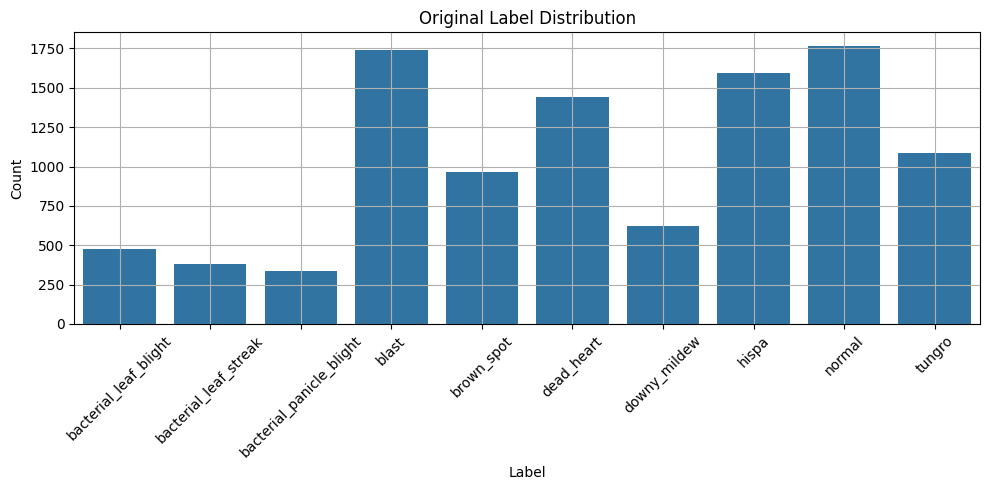

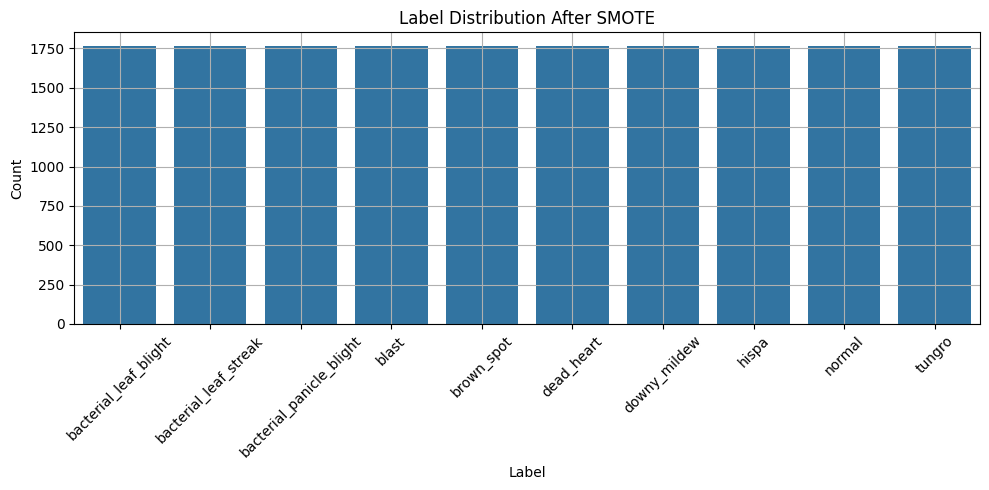

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Before SMOTE: Class Distribution ===
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='label')
plt.title("Original Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# === After SMOTE: Class Distribution ===
plt.figure(figsize=(10, 5))
sns.countplot(data=df_resampled, x='label')
plt.title("Label Distribution After SMOTE")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


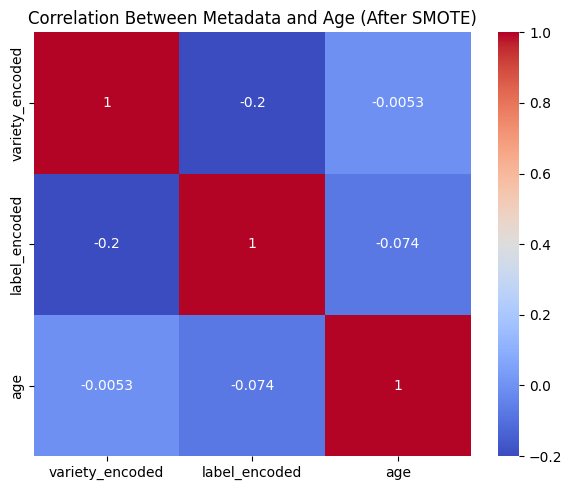

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recalculate correlation using resampled data
plt.figure(figsize=(6, 5))
sns.heatmap(
    df_resampled[['variety_encoded', 'label_encoded', 'age']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation Between Metadata and Age (After SMOTE)')
plt.tight_layout()
plt.show()


In [14]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import albumentations as A

# === CONFIG ===
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))

PATHS = {
    "train_images": os.path.join(BASE_PATH, "dataset", "train"),
    "augmented_images": os.path.join(BASE_PATH, "dataset", "train_augmented"),
    "augmented_csv": os.path.join(BASE_PATH, "meta_aug_train.csv")
}

os.makedirs(PATHS["augmented_images"], exist_ok=True)

# === YOUR df_resampled goes here ===
# Make sure df_resampled contains: ['image_id', 'label', 'variety', 'age']
# If needed, assign image_id to each row (e.g., randomly sample from original images with same label)

# === Augmentation Pipeline ===
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomCrop(width=224, height=224),
    A.Resize(256, 256)
])

augmented_records = []

import random

# Load original df that has correct image_id -> label mapping
df_original = pd.read_csv(os.path.join(BASE_PATH, "meta_train.csv"))

# Create mapping from label to image_ids
label_to_images = df_original.groupby("label")['image_id'].apply(list).to_dict()

# Assign image_id to each row in df_resampled
assigned_ids = []
for _, row in df_resampled.iterrows():
    candidates = label_to_images.get(row['label'], [])
    if candidates:
        assigned_ids.append(random.choice(candidates))
    else:
        assigned_ids.append(None)

df_resampled['image_id'] = assigned_ids


for i, row in tqdm(df_resampled.iterrows(), total=len(df_resampled)):
    # Use the original image_id or randomly assign one from same label
    image_filename = row.get('image_id', None)
    if image_filename is None:
        continue  # Assign logic here if needed

    # Locate image
    image_path = None
    for root, dirs, files in os.walk(PATHS["train_images"]):
        if image_filename in files:
            image_path = os.path.join(root, image_filename)
            break

    if image_path is None:
        continue

    # Load and augment
    image = np.array(Image.open(image_path).convert("RGB"))
    transformed = transform(image=image)['image']
    new_filename = f"aug_{i}_{image_filename}"
    save_path = os.path.join(PATHS["augmented_images"], new_filename)
    Image.fromarray(transformed).save(save_path)

    # Record metadata
    augmented_records.append({
        'image_id': new_filename,
        'label': row['label'],
        'variety': row['variety'],
        'age': row['age']
    })

# === Save new CSV ===
df_augmented = pd.DataFrame(augmented_records)
df_augmented.to_csv(PATHS["augmented_csv"], index=False)
print("Augmented images and metadata saved.")


100%|████████████████████████████████████| 17640/17640 [01:32<00:00, 190.36it/s]

Augmented images and metadata saved.


In [26]:
import os

missing_train = df_train[~df_train['full_path'].apply(os.path.exists)]
missing_val = df_val[~df_val['full_path'].apply(os.path.exists)]

print(f"Missing training files: {missing_train.shape[0]}")
print(f"Missing validation files: {missing_val.shape[0]}")
print("Example missing val paths:")
print(missing_val[['filename', 'full_path']].head())


Missing training files: 8326
Missing validation files: 2081
Example missing val paths:
        filename                                          full_path
3952  110123.jpg  /Users/anluu/Library/CloudStorage/OneDrive-RMI...
4597  103408.jpg  /Users/anluu/Library/CloudStorage/OneDrive-RMI...
9621  106214.jpg  /Users/anluu/Library/CloudStorage/OneDrive-RMI...
8620  100525.jpg  /Users/anluu/Library/CloudStorage/OneDrive-RMI...
4294  104673.jpg  /Users/anluu/Library/CloudStorage/OneDrive-RMI...


Total combined samples: (24457, 5)
Train: (19565, 6) Val: (4892, 6)
Found 11290 validated image filenames.
Found 2760 validated image filenames.


/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 8275 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2132 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20


2025-06-04 20:03:57.376639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


353/353 [==============================] - ETA: 0s - loss: 1762.6533 - mae: 38.7873 - r_squared: -22.2986 - rmse: 40.0792

2025-06-04 20:05:03.213678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


353/353 [==============================] - 72s 197ms/step - loss: 1762.6533 - mae: 38.7873 - r_squared: -22.2986 - rmse: 40.0792 - val_loss: 2465.6353 - val_mae: 47.2116 - val_r_squared: -31.6500 - val_rmse: 49.6326
Epoch 2/20
353/353 [==============================] - 65s 185ms/step - loss: 243.4963 - mae: 13.5499 - r_squared: -2.2373 - rmse: 15.2283 - val_loss: 275.4248 - val_mae: 14.2362 - val_r_squared: -2.6748 - val_rmse: 16.5741
Epoch 3/20
353/353 [==============================] - 66s 186ms/step - loss: 88.0612 - mae: 8.1110 - r_squared: -0.1441 - rmse: 9.3339 - val_loss: 84.4225 - val_mae: 7.7073 - val_r_squared: -0.0691 - val_rmse: 9.1535
Epoch 4/20
353/353 [==============================] - 66s 187ms/step - loss: 72.0079 - mae: 7.0722 - r_squared: 0.0866 - rmse: 8.4412 - val_loss: 116.5404 - val_mae: 7.4985 - val_r_squared: -0.4505 - val_rmse: 10.6748
Epoch 5/20
353/353 [==============================] - 65s 184ms/step - loss: 66.2658 - mae: 6.6774 - r_squared: 0.1606 - rmse:

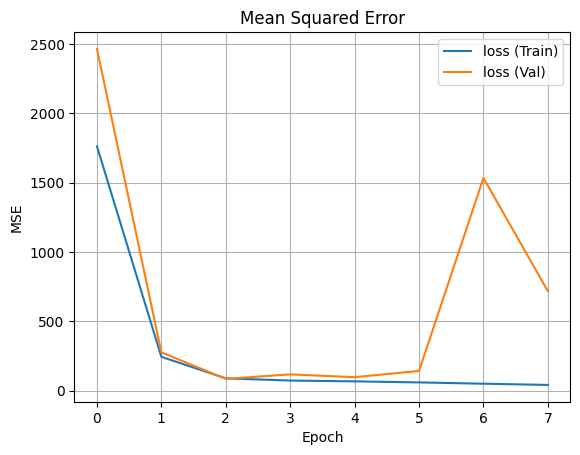

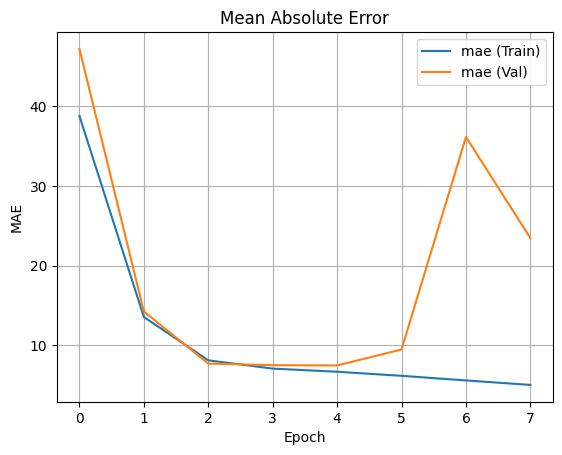

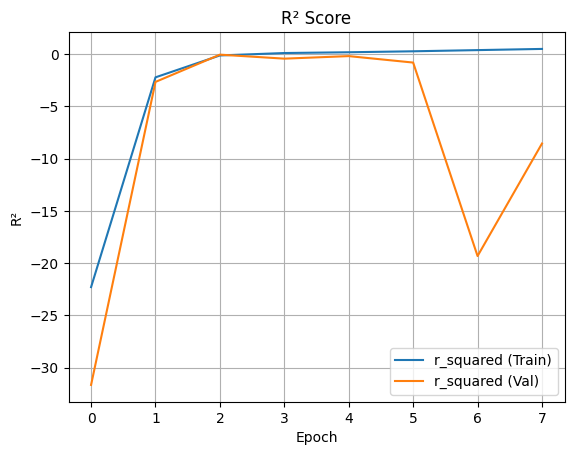

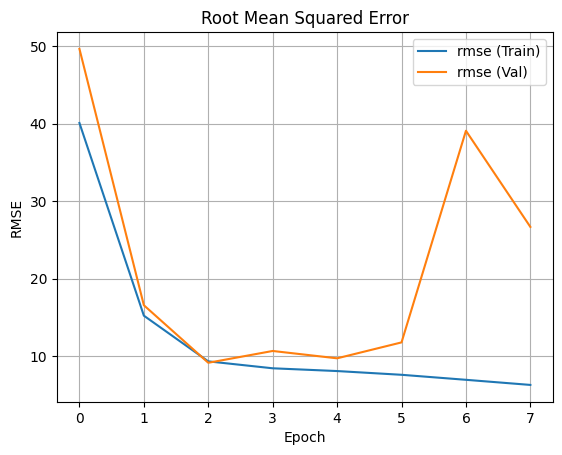

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
import tensorflow as tf
from PIL import Image

# === CONFIG ===
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))
ORIG_CSV = os.path.join(BASE_PATH, "meta_train.csv")
AUG_CSV = os.path.join(BASE_PATH, "meta_aug_train.csv")
IMG_DIR_ORIG = os.path.join(BASE_PATH, "dataset", "train")
IMG_DIR_AUG = os.path.join(BASE_PATH, "dataset", "train_augmented")
OUTPUT_DIR = os.path.join(BASE_PATH, "outputs_task3")
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 20

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Load CSVs ===
df_orig = pd.read_csv(ORIG_CSV)
df_aug = pd.read_csv(AUG_CSV)

df_orig['filename'] = df_orig['image_id']
df_orig['age'] = df_orig['age'].astype(float)

df_aug['filename'] = df_aug['image_id']
df_aug['age'] = df_aug['age'].astype(float)

df_combined = pd.concat([df_orig, df_aug], ignore_index=True)
print("Total combined samples:", df_combined.shape)

# === Add full image paths ===
def get_path(row):
    base = IMG_DIR_AUG if row['filename'].startswith('aug_') else IMG_DIR_ORIG
    return os.path.join(base, row['filename'])

df_combined['full_path'] = df_combined.apply(get_path, axis=1)

# === Split Train/Val ===
df_train, df_val = train_test_split(df_combined, test_size=0.2, random_state=42)
print("Train:", df_train.shape, "Val:", df_val.shape)

# === Data Generator (regression version) ===
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='full_path',
    y_col='age',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='full_path',
    y_col='age',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# === Custom Metrics ===
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# === Build Model ===
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = True

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
out = Dense(1)(x)  # Regression

model = Model(inputs=base.input, outputs=out)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae', r_squared, rmse]
)

# === Train Model ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[early_stop])

# === Plot Loss and Metrics ===
def plot_metric(metric_name, title, ylabel):
    plt.plot(history.history[metric_name], label=f'{metric_name} (Train)')
    plt.plot(history.history[f'val_{metric_name}'], label=f'{metric_name} (Val)')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{metric_name}.png"))
    plt.show()

plot_metric('loss', 'Mean Squared Error', 'MSE')
plot_metric('mae', 'Mean Absolute Error', 'MAE')
plot_metric('r_squared', 'R² Score', 'R²')
plot_metric('rmse', 'Root Mean Squared Error', 'RMSE')


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers.legacy import Adam

import tensorflow.keras.backend as K
import tensorflow as tf

# === CONFIG ===
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))
ORIG_CSV = os.path.join(BASE_PATH, "meta_train.csv")
AUG_CSV = os.path.join(BASE_PATH, "meta_aug_train.csv")
IMG_DIR_ORIG = os.path.join(BASE_PATH, "dataset", "train")
IMG_DIR_AUG = os.path.join(BASE_PATH, "dataset", "train_augmented")
OUTPUT_DIR = os.path.join(BASE_PATH, "outputs_task3")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Load CSVs ===
df_orig = pd.read_csv(ORIG_CSV)
df_aug = pd.read_csv(AUG_CSV)

df_orig['filename'] = df_orig['image_id']
df_aug['filename'] = df_aug['image_id']
df_orig['age'] = df_orig['age'].astype(float)
df_aug['age'] = df_aug['age'].astype(float)

# === Combine ===
df_combined = pd.concat([df_orig, df_aug], ignore_index=True)
print("Total combined samples:", df_combined.shape)

# === Normalize Age ===
scaler = MinMaxScaler()
df_combined['age'] = scaler.fit_transform(df_combined[['age']])

# === Add Full Image Path ===
# === Split Train/Val ===
df_val = df_orig.sample(frac=0.2, random_state=42)
df_train = df_combined[~df_combined['filename'].isin(df_val['filename'])]

# === Add Full Image Path ===
def get_path(row):
    base = IMG_DIR_AUG if row['filename'].startswith('aug_') else IMG_DIR_ORIG
    return os.path.join(base, row['filename'])

df_train['full_path'] = df_train.apply(get_path, axis=1)
df_val['full_path'] = df_val.apply(get_path, axis=1)

print("Train:", df_train.shape, "Val:", df_val.shape)

# === Data Generator (regression version) ===
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='full_path',
    y_col='age',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='full_path',
    y_col='age',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# === Custom Metrics ===
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# === Build Model ===
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = True

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
out = Dense(1)(x)

# === Cosine Decay Learning Rate ===
lr_schedule = CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    alpha=1e-6
)

model = Model(inputs=base.input, outputs=out)
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='mean_squared_error',
    metrics=['mae', rmse, r_squared]
)

# === Train Model ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

# === Plot Loss and Metrics ===
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[metric_name], label=f"{metric_name} (Train)")
    plt.plot(history.history[f"val_{metric_name}"], label=f"{metric_name} (Val)")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{metric_name}.png"))
    plt.show()

plot_metric('loss', 'Mean Squared Error', 'MSE')
plot_metric('mae', 'Mean Absolute Error', 'MAE')
plot_metric('r_squared', 'R² Score', 'R²')
plot_metric('rmse', 'Root Mean Squared Error', 'RMSE')


Total combined samples: (24472, 5)
Train: (22391, 6) Val: (2081, 6)
Found 14065 validated image filenames.
Found 0 validated image filenames.


/var/folders/l_/2tbf5tf961vg06w5znf_dhnr0000gn/T/ipykernel_3495/996868008.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['full_path'] = df_train.apply(get_path, axis=1)
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 8326 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2081 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/50


2025-06-04 21:52:11.391824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/440 [===============>..............] - ETA: 34s - loss: 0.2625 - mae: 0.3875 - rmse: 0.4830 - r_squared: -3.5722